In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline



import matplotlib.pyplot as plt
import seaborn as sns

In [6]:

train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head(10)

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
5,5,직장 내 괴롭힘 대화,나 이틀뒤에 가나다 음식점 예약좀 해줘. 저녁7시로.\n가나다 음식점이요.?\n응....
6,6,기타 괴롭힘 대화,35번 손님 아이스커피 두잔나왔습니다\n아이스커피? \n네 맛있게드세요\n저기요 아...
7,7,기타 괴롭힘 대화,경비아저씨 내차에 경고장 붙였어요?\n내가 여기 몇년째 사는데 아직도 내차인줄 모르...
8,8,기타 괴롭힘 대화,이거 할인 된다면서요\n 확인해보겠습니다\n 아까 저 시람은 할인 해주던데\n 네 ...
9,9,갈취 대화,자네 세금계산서 보내준 거 메일이랑 수치가 다르던데?\n그게.\n얼마나 해먹었어? ...


In [7]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

train_data['class'] = encoder.transform(train_data['class'])

corpus = train_data["conversation"]

In [8]:
#
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=10000, 
        filters=' ',
        oov_token="<unk>")
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)



# 1. TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
# 2. 텍스트 데이터 변환
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['conversation'][:3500])
X_val_tfidf = tfidf_vectorizer.transform(train_data['conversation'][3500:3850])
X_test_tfidf = tfidf_vectorizer.transform(train_data['conversation'][3850:])


[[5527  210 5528 ... 5530   41 5531]
 [7965 7966    1 ...    1    1  396]
 [   1   96    1 ...    1  125    1]
 ...
 [ 485    3  113 ...   27 2015 5457]
 [   1    1  152 ...  350    1 3109]
 [   1    1    1 ...  156  114    1]] <keras_preprocessing.text.Tokenizer object at 0x7f523383c460>


In [9]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 30: break

1 : <unk>
2 : 내가
3 : 너
4 : 좀
5 : 다
6 : 왜
7 : 나
8 : 진짜
9 : 야
10 : 지금
11 : 돈
12 : 안
13 : 이
14 : 그냥
15 : 내
16 : 제가
17 : 거
18 : 더
19 : 이거
20 : 그렇게
21 : 무슨
22 : 잘
23 : 그럼
24 : 그
25 : 어떻게
26 : 우리
27 : 너무
28 : 니
29 : 수
30 : 저


In [11]:
X_train = tensor[:3500]
y_train = train_data['class'][:3500]
X_val = tensor[3500:3850]
y_val = train_data['class'][3500:3850]
X_test = tensor[3850:]
y_test = train_data['class'][3850:]

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.25142857142857145
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.20      0.23        79
           1       0.24      0.61      0.35        83
           2       0.32      0.20      0.24        91
           3       0.14      0.03      0.05        97

    accuracy                           0.25       350
   macro avg       0.24      0.26      0.22       350
weighted avg       0.24      0.25      0.21       350



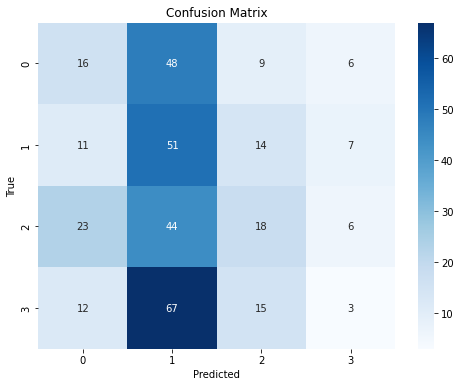

In [12]:
# 1. LinearSVC 모델훈련
model = LinearSVC()
model.fit(X_train, y_train)

# 예측수행
y_pred = model.predict(X_val)

# 정확도 계산
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# 분류 보고서 출력
classification_rep = classification_report(y_val, y_pred)
print("Classification Report:\n", classification_rep)

# Confusion Matrix를 계산
cm = confusion_matrix(y_val, y_pred)

# Confusion Matrix를 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

/tmp/ipykernel_57/1799339155.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', linestyle='--')
/tmp/ipykernel_57/1799339155.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', linestyle='--')


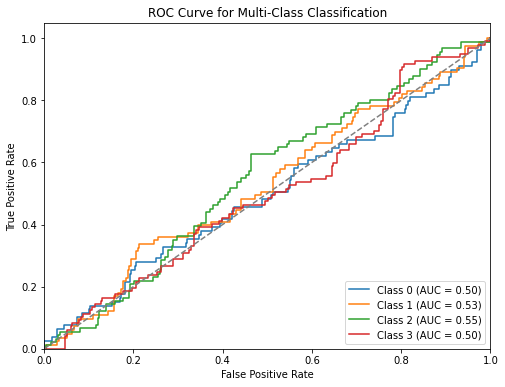

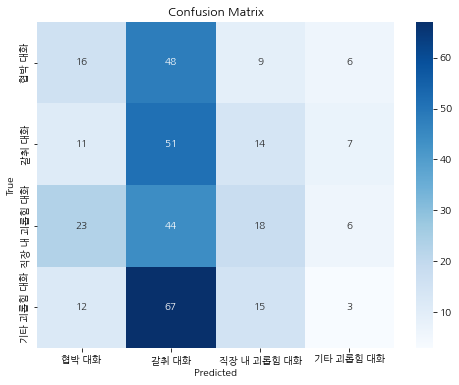

In [13]:
# 검증 데이터에 대한 예측 확률
y_pred_prob = model.decision_function(X_val)

# 다중 클래스 ROC 곡선 시각화
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(CLASS_NAMES)):
    fpr[i], tpr[i], _ = roc_curve(y_val, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 시각화
plt.figure(figsize=(8, 6))
for i in range(len(CLASS_NAMES)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix를 계산하고 시각화
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
plt.rcParams['font.family'] = 'NanumGothic'  # 한글 폰트 설정(기본으로 하니까 깨져서 출력)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

/tmp/ipykernel_57/2336053438.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', linestyle='--')
/tmp/ipykernel_57/2336053438.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', linestyle='--')


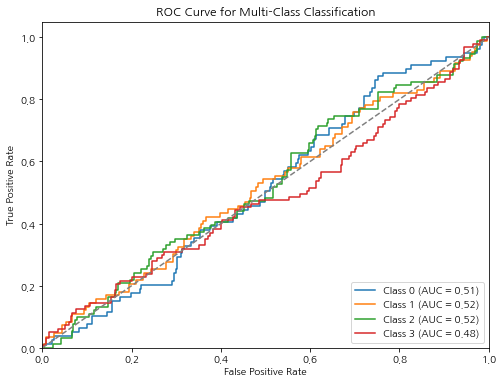

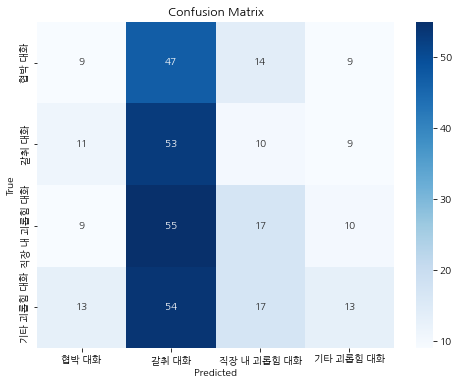

Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.11      0.15        79
           1       0.25      0.64      0.36        83
           2       0.29      0.19      0.23        91
           3       0.32      0.13      0.19        97

    accuracy                           0.26       350
   macro avg       0.27      0.27      0.23       350
weighted avg       0.27      0.26      0.23       350



In [14]:
# 2. Softmax Regression 모델을 훈련
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)


# 검증 데이터에 대한 예측 확률
y_pred_prob = model.predict_proba(X_val)

# 다중 클래스 ROC 곡선을 계산하고 시각화
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(CLASS_NAMES)):
    fpr[i], tpr[i], _ = roc_curve(y_val, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 시각화
plt.figure(figsize=(8, 6))
for i in range(len(CLASS_NAMES)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix를 계산하고 시각화
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 분류 보고서 출력
classification_rep = classification_report(y_val, y_pred)
print("Classification Report:\n", classification_rep)

/tmp/ipykernel_57/1271821802.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', linestyle='--')
/tmp/ipykernel_57/1271821802.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', linestyle='--')


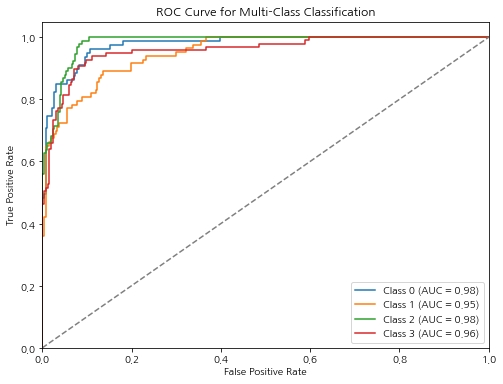

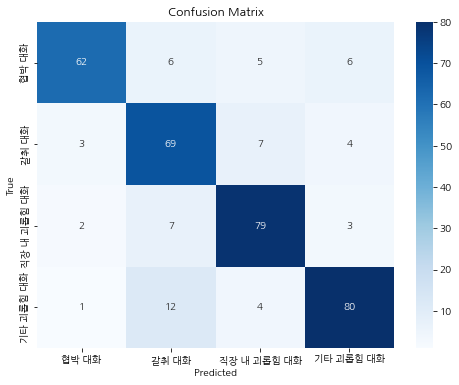

In [28]:
#3. logisticRegression + TF-IDF
model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
model.fit(X_train_tfidf, y_train)

# ROC 곡선 계산 및 시각화
y_pred_prob = model.predict_proba(X_val_tfidf)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(CLASS_NAMES)):
    fpr[i], tpr[i], _ = roc_curve(y_val, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(CLASS_NAMES)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

# 혼동 행렬 및 분류 보고서
y_pred = model.predict(X_val_tfidf)
cm = confusion_matrix(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [16]:
''''import json
import os
import pandas as pd

# 파일 경로 생성
file_path = os.path.expanduser('~/aiffel/dktc/data/test.json')
with open(file_path, 'r', encoding='utf-8') as file:
    test_data = json.load(file)

test_data[0] if isinstance(test_data, list) else test_data
